In [4]:
### GENERAL REQUIREMENTS - will install the libraries

import pandas as pd
import numpy as np
import math
import nltk
import requests
import re
import json
import io
import time # to avoid errors, we sometime use time.sleep(N) before retrying a request
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import geopandas
from shapely.geometry import Point
from functools import partial
from shapely.ops import transform
import pyproj

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import seaborn as sns
import geoplot

from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

import sddk

In [5]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:
conf = sddk.configure()

# (1) read the file and parse its content
file_data = conf[0].get(conf[1] + "ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)
# (5) establish connection with spreadsheets specified by their url
occupations = gc.open_by_url("https://docs.google.com/spreadsheets/d/1nONTEwp42CVnq3iCiONrFbJedIcYtBV-l4Bil5mU7Eo/edit?usp=sharing")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [6]:
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [195]:
# read the datasets
publicfolder = "e0f9cd400dd05584fe06fe1d804deff0"
EDH = sddk.read_file("EDH_occupsorgs_2021-02-26.json", "df", publicfolder)
EDCS = sddk.read_file("EDCS_occupsorgs_2021-02-26.json", "df", publicfolder)

reading file located in a public folder
reading file located in a public folder


In [196]:
# length of the original dataset
print(len(EDH))
print(len(EDCS))

81476
500618


# Filter by language

In [217]:
# focus on latin inscriptions only
EDH = EDH[EDH["language"].notnull()]
EDH = EDH[EDH["language"].str.contains("Latin")]
print(len(EDH))

# focus on latin inscriptions only
EDCS = EDCS[EDCS["language"].isnull()]
print(len(EDCS))

80177
98825


# Remove EDH by Links

In [198]:
# identify overlapping inscriptions
links_with_edh = EDCS[EDCS["Links"].str.contains("edh", na=False)]["Links"].tolist()
edh_ids = [link.rpartition("edh/inschrift/")[2].split()[0] for link in links_with_edh]


In [199]:
# remove them from the dataset
EDCS = EDCS[~EDCS["Links"].str.contains("edh", na=False)]
len(EDCS)

405372

In [376]:
pd.options.display.max_columns = 1000

# Filter by dating

In [200]:
# having at least some form of date
EDCS = EDCS[(EDCS["dating from"].notnull()) | (EDCS["dating to"].notnull())]
len(EDCS)

98972

In [207]:
# this date being numeric
def to_int(date_str):
    try: return int(date_str)
    except: return None
    
EDCS["dating from"] = EDCS["dating from"].apply(to_int)
EDCS["dating to"] = EDCS["dating to"].apply(to_int)

In [213]:
# this date within the desired range
EDCS = (EDCS[(EDCS["dating from"].between(-50, 350) | (EDCS["dating to"].between(-50, 350)))])

88270

# Deduplicate EDH & EDCS

In [214]:
len(edh_ids)

72177

In [218]:
# inscriptions only in EDH
EDH_unique = EDH[~EDH["id"].isin(edh_ids)]
len(EDH_unique)

9250

In [219]:
# having at least some text
EDH_unique = EDH_unique[EDH_unique["clean_text_interpretive_word"].notnull()]
len(EDH_unique)

9247

In [220]:
EDH_unique_dict = {}
EDH_unique_tups = [tup for tup in zip(EDH_unique["clean_text_interpretive_word"].tolist(), EDH_unique["id"])]
for text, edh_id in EDH_unique_tups:
    EDH_unique_dict[text] = [tup[1] for tup in EDH_unique_tups if tup[0] == text]

In [221]:
len(EDH_unique_dict)

8420

In [222]:
def match_text(edcs_str):
    try: return EDH_unique_dict[edcs_str]
    except: return None
    
EDCS["edh_candidates"] = EDCS["clean_text_interpretive_word"].apply(match_text)

In [223]:
len(EDCS[EDCS["edh_candidates"].notnull()])

4849

In [224]:
EDCS[EDCS["edh_candidates"].notnull()].head(5)

,EDCS-ID,publication,province,place,notes_dating,notes_references,notes_comments,inscription,inscription_stripped14,clean_text_interpretive_word,...,Latitude,Longitude,photo,Material,Comment,occups,occups_N,organizations,organizations_N,edh_candidates
2700,EDCS-58200154,Didymoi 00229,Aegyptus,Dios / Latomia Dios / Didymoi,,,,[3[[3 ni]]],[3[[3 ni]]],ni,...,25.187415,34.086320,None,opus figlinae,None,[],0,[],0,[HD077582]
3502,EDCS-47900995,"CIL 11, 06712,499a = InstrInscr-05, p 340,50",Aemilia / Regio VIII,Bologna / Bononia,,,,Ut(ere) f(elix),Ut(ere) f(elix),Utere felix,...,44.4938605,11.3429718,None,None,None,[],0,[],0,[HD080742]
4370,EDCS-08100097,"SupIt-17-Fe, 00034",Aemilia / Regio VIII,Ferrara,,,,?,?,,...,44.8372737,11.6186451,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,lapis,unleserlicher Text,[],0,[],0,"[HD079887, HD081183, HD081185, HD081194, HD081..."
4497,EDCS-10900004,"SupIt-10-FL, 00004",Aemilia / Regio VIII,Forli / Forum Livii,,,,]AI[,]AI[,AI,...,44.2227182,12.0412435,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,None,None,[],0,[],0,"[HD077256, HD078436, HD079814]"
4498,EDCS-10900005,"SupIt-10-FL, 00005",Aemilia / Regio VIII,Forli / Forum Livii,,,,]F[,]F[,F,...,44.2227182,12.0412435,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,None,None,[],0,[],0,"[HD077079, HD077081, HD079363, HD079364]"


In [371]:
thresh = 1

def evaluate_candidates(edcs_row):
    spatial_differences = []
    try:
        long_x, lat_y = float(edcs_row["Longitude"]), float(edcs_row["Latitude"])
        for edh_candidate_id in edcs_row["edh_candidates"]:
            edh_candidate_row = EDH_unique.loc[EDH_unique["id"]==edh_candidate_id]
            edh_long_x, edh_lat_y = edh_candidate_row["coordinates"][0][0], edh_candidate_row["coordinates"][0][1]
            long_dif = abs(edh_long_x - long_x)
            lat_dif = abs(edh_lat_y - lat_y)
            if ((long_dif < thresh) & (lat_dif < thresh)):
                spatial_differences.append([edcs_row["EDCS-ID"], [long_x, lat_y], edh_candidate_id, [edh_long_x, edh_lat_y], long_dif, lat_dif])
    except: 
        #print("not working")
        pass
    return spatial_differences

In [373]:
edcs_edh = [el for el in EDCS[EDCS["edh_candidates"].notnull()].apply(lambda row: evaluate_candidates(row), axis=1).tolist() if len(el) > 0]
edcs_edh

[[['EDCS-57600020',
   [7.0539789, 45.1372115],
   'HD065962',
   [7.0482, 45.1379],
   0.005778900000000142,
   0.0006885000000025343]],
 [['EDCS-31300280',
   [35.766667, 31.0],
   'HD023381',
   [35.8757, 31.417],
   0.10903300000000371,
   0.4170000000000016]],
 [['EDCS-10700576',
   [7.187221, 51.7430516],
   'HD080265',
   [7.1872, 51.7431],
   2.1000000000270802e-05,
   4.839999999717293e-05]],
 [['EDCS-75000269',
   [6.9487853, 51.0528023],
   'HD081817',
   [6.9488, 51.0528],
   1.4700000000367197e-05,
   2.300000005561742e-06]],
 [['EDCS-10601218',
   [6.3984866, 49.9413268],
   'HD079887',
   [6.0838, 50.7754],
   0.3146865999999999,
   0.8340731999999988],
  ['EDCS-10601218',
   [6.3984866, 49.9413268],
   'HD081183',
   [6.9597, 50.9401],
   0.5612133999999998,
   0.9987732000000022],
  ['EDCS-10601218',
   [6.3984866, 49.9413268],
   'HD081185',
   [6.9597, 50.9401],
   0.5612133999999998,
   0.9987732000000022],
  ['EDCS-10601218',
   [6.3984866, 49.9413268],
   'HD08119

In [380]:
len(edcs_edh)

643

In [381]:
EDH_unique.head(5)

,responsible_individual,type_of_inscription,letter_size,not_after,literature,work_status,height,diplomatic_text,people,depth,material,type_of_monument,province_label,width,transcription,country,uri,findspot_ancient,last_update,modern_region,findspot_modern,language,id,edh_geography_uri,commentary,trismegistos_uri,not_before,external_image_uris,fotos,coordinates,idno_tm,placenames_refs,text_edition,origdate_text,layout_execution,layout_execution_text,support_objecttype,support_objecttype_text,support_material,support_material_text,support_decoration,keywords_term,keywords_term_text,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,origdate_text_clean,clean_text_conservative,clean_text_interpretive_word,clean_text_interpretive_sentence,findspot,year_of_find,present_location,religion,geography,social_economic_legal_history,military,occups,occups_N,organizations,organizations_N
6,Feraudi,epitaph,9 cm,-0051,"AE 1983, 0033. (C); G. Pisani Sartorio, in: G....",checked with photo,35 cm,CLODIA M F,"[{'name': 'Clodia M.f.', 'nomen': 'Clodia', 'g...",None,travertine: rocks - chemische Sedimente,tabula,Roma,53 cm,Clodia M(arci) f(ilia),Italy,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Roma,2010-01-04,Lazio,Roma,Latin,HD000007,https://edh-www.adw.uni-heidelberg.de/edh/geog...,(C): Datierung: Zeit Sullas.,https://www.trismegistos.org/text/265588,-0100,{},{},"[12.4823, 41.8955]",265588,"[http://www.trismegistos.org/place/000172, htt...",Clodia Marci filia,100 BC – 51 BC,21,unbestimmt,257,Tafel,71,Travertin,1000,92,Grabinschrift,epitaph,Certain,35.0,53.0,NaN,Travertine,tabula,Certain,Roma,Certain,Italy,Certain,Roma,Certain,Lazio,Certain,Roma,Certain,"Via Nomentana, Tor Lupara",Certain,100 BC – 51 BC,Clodia M f,Clodia Marci filia,Clodia Marci filia,"Via Nomentana, Tor Lupara",None,"Mentana, Privatbesitz",None,None,None,None,[],0,[],0
7,Feraudi,epitaph,4-2 cm,0200,"AE 1983, 0060.; R. Palmieri, in: G. Barbieri (...",provisional,52 cm,D M / C SATRIO XANTHO / C SATRI RVFI LIB / DEC...,"[{'gender': 'male', 'nomen': 'Satrius', 'name'...",None,marble: rocks - metamorphic rocks,tabula,Roma?,65 cm,D(is) M(anibus) / C(aio) Satrio Xantho / C(ai)...,Italy,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Roma?,2013-12-03,Lazio?,Roma?,Latin,HD000008,https://edh-www.adw.uni-heidelberg.de/edh/geog...,Tafel aus mehreren anpassenden Fragmenten zus...,https://www.trismegistos.org/text/265611,0101,{},[https://edh-www.adw.uni-heidelberg.de/fotos/F...,"[12.4823, 41.8955]",265611,"[http://www.trismegistos.org/place/000172, htt...",Dis Manibus Caio Satrio Xantho Cai Satri Rufi ...,101 AD – 200 AD,21,unbestimmt,257,Tafel,48,Marmor,1000,92,Grabinschrift,epitaph,Certain,52.0,65.0,NaN,Marble,tabula,Certain,Roma,Uncertain,Italy,Certain,Roma,Uncertain,Lazio,Uncertain,Roma,Uncertain,NULL,NULL,101 AD – 200 AD,D M C Satrio Xantho C Satri Rufi lib decuriali...,Dis Manibus Caio Satrio Xantho Cai Satri Rufi ...,Dis Manibus Caio Satrio Xantho Cai Satri Rufi ...,None,None,"Mentana, Privatbesitz",None,None,None,None,[],0,[],0
10,Feraudi,epitaph,5-3 cm,0068,"AE 1983, 0058.; L. Polverini, in: G. Barbieri ...",provisional,(57) cm,VETVS / NERONIS CLAVD / CAESAR AVG / CORP CVS ...,"[{'gender': 'male', 'origo': 'Batavus+', 'pers...",13 cm,marble: rocks - metamorphic rocks,stele,Latium et Campania (Regio I),52 cm,Vetus / Neronis Claud(i) / Caesar(is) Aug(usti...,Italy,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Roma,2013-12-03,Lazio,Roma,Latin,HD000011,https://edh-www.adw.uni-heidelberg.de/edh/geog...,"F. Münzer, RE XVIII 1 (1936), 41: Claudius wä...",https://www.trismegistos.org/text/267221,0054,{},https://edh-www.adw.uni-heidel

In [389]:
def get_edcs(trismegistos_uri):
    try:
        url = "https://www.trismegistos.org/dataservices/texrelations/{}".format(trismegistos_uri.rpartition("/")[2])
        resp = requests.get(url)
        edcs_ids = resp.json()[3]["EDCS"]
        return edcs_ids
    except: 
        return None

In [ ]:
%%time
EDH_unique["edcs_ids"] = EDH_unique["trismegistos_uri"].apply(get_edcs)

In [ ]:
edcs_to_edh_dict = {}
for edh_id, edcs_ids in zip(EDH_unique["id"], EDH_unique["edcs_ids"]):
    for edcs_id in edcs_ids:
        edcs_to_edh_dict[edcs_id] = edh_id

In [ ]:
sddk.write_file("SDAM_data/social_diversity/edcs_to_edh_dict.json", edcs_to_edh_dict, conf)

# Create geodataframes

In [12]:
# EDH as geodataframe
EDHg = EDH[EDH["coordinates"].apply(lambda x: isinstance(x, list))]
EDHg = geopandas.GeoDataFrame(EDHg, geometry=geopandas.points_from_xy(EDHg["coordinates"].apply(lambda x: x[0]), EDHg["coordinates"].apply(lambda x: x[1])), crs={"init": "epsg:3857"})

In [13]:
# EDCS as geodataframe
EDCS = EDCS[EDCS["Latitude"].notnull()]
EDCSg = geopandas.GeoDataFrame(EDCS, geometry=geopandas.points_from_xy(EDCS["Longitude"], EDCS["Latitude"]))

# Import cities and regions

In [14]:
# read hanson's cities
cities_pop = sddk.read_file("SDAM_data/urban/roman_cities.json", "df", conf)

In [15]:
cities_pop.head(5)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Longitude (X),...,Select Bibliography,Area,Estimate Basis,Civic Status,Structure,num_of_structures,ID,pop_sample,pop_est,pop_diff
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,22.933333,...,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,16.0,Walls,[Rights and privileges],"[Acropolis, Agora, Temple of Apollo, Theatre, ...",5,1,NaN,1700.0,NaN
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,23.734088,...,BNP; DGRG; PECS; Sear 2006.,NaN,None,None,"[Sanctuary of Apollo Argyieus, Sanctuary of He...",3,2,NaN,1000.0,NaN
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,23.219702,...,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,NaN,None,None,"[Acropolis, Agora, Fountain, Temple of Apollo ...",7,3,NaN,1000.0,NaN
3,Hanson2016_4,Aegina,Aigina,Achaea,Greece,2,59 A3,-600,NaN,23.428500,...,BNP; DGRG; Hansen 2006; Hansen and Nielsen 200...,52.0,Inhabited area,[Rights and privileges],"[Shrine of Aeacus, Stadium, Temple of Aphrodit...",8,4,NaN,8209.0,NaN
4,Hanson2016_5,Aegira,Aigeira,Achaea,Greece,3,58 C1,-600,NaN,22.355720,...,DGRG; Hansen and Nielsen 2004.,NaN,None,None,"[Acropolis, Agora, Gymnasium, Temple of Aphrod...",8,5,NaN,1000.0,NaN


In [16]:
cities_pop.columns

Index(['Primary Key', 'Ancient Toponym', 'Modern Toponym', 'Province',
       'Country', 'Barrington Atlas Rank', 'Barrington Atlas Reference',
       'Start Date', 'End Date', 'Longitude (X)', 'Latitude (Y)',
       'Select Bibliography', 'Area', 'Estimate Basis', 'Civic Status',
       'Structure', 'num_of_structures', 'ID', 'pop_sample', 'pop_est',
       'pop_diff'],
      dtype='object')

In [17]:
cities_pop = geopandas.GeoDataFrame(cities_pop, geometry=geopandas.points_from_xy(cities_pop["Longitude (X)"], cities_pop["Latitude (Y)"]), crs={"init":"epsg:3857"})

In [18]:
### # pelagios provinces - only for plotting purposes
url = "https://raw.githubusercontent.com/pelagios/magis-pleiades-regions/main/pleiades-regions-magis-pelagios.geojson"
pleiades_regions = geopandas.read_file(url, crs={"init": "epsg:3857"})
pleiades_regions.head()

,name,uri,geometry
0,Lusitania,http://pleiades.stoa.org/places/1101,"POLYGON ((-7.31057 37.19663, -7.32457 37.19556..."
1,Byzacena,http://pleiades.stoa.org/places/991345,"MULTIPOLYGON (((11.01815 34.62424, 11.00879 34..."
2,Viennensis,http://pleiades.stoa.org/places/992074,"POLYGON ((4.62344 45.60642, 4.71224 45.60876, ..."
3,Lycia et Pamphylia,http://pleiades.stoa.org/places/981530,"MULTIPOLYGON (((29.62331 36.07470, 29.61295 36..."
4,Savia,http://pleiades.stoa.org/places/991357,"POLYGON ((18.10598 45.77203, 18.10654 45.71079..."


In [19]:
# merge the regions into one multipolygon
RE_merged = pleiades_regions.unary_union

In [25]:
def re_by_id(id, dataset=None):
    if dataset == "EDH":
        try: return EDH_within_RE_dict[id]
        except: return False
    elif dataset == "EDCS":
        try: return EDCS_within_RE_dict[id]
        except: return False
    else:
        return False

In [26]:
# previously computed inscriptions within RE
EDH_within_RE_dict = sddk.read_file("SDAM_data/social_diversity/EDH_within_RE_dict.json", "dict", conf)
EDHg["within_RE"]= EDHg["id"].apply(re_by_id, dataset="EDH")
# to recompute, uncomment the following (takes approx five minutes):
#EDHg["within_RE"] = EDHg.within(RE_merged)
#EDH_within_RE_dict = dict(zip(EDHg["id"].tolist(), EDHg["within_RE"]))
#sddk.write_file("SDAM_data/social_diversity/EDH_within_RE_dict.json", EDH_within_RE_dict, conf)

In [27]:
%%time

EDCS_within_RE_dict = sddk.read_file("SDAM_data/social_diversity/EDCS_within_RE_dict.json", "dict", conf)
EDCSg["within_RE"]= EDCSg["id"].apply(re_by_id, dataset="EDCS")
# to recompute, uncomment the following (takes approx 30 minutes):
#EDCSg["within_RE"] = EDCSg.within(RE_merged)
#EDCS_within_RE_dict = dict(zip(EDCSg["EDCS-ID"].tolist(), EDCSg["within_RE"]))
#sddk.write_file("SDAM_data/social_diversity/EDCS_within_RE_dict.json", EDCS_within_RE_dict, conf)

Your <class 'dict'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/EDCS_within_RE_dict.json"
CPU times: user 34min 57s, sys: 59.2 ms, total: 34min 57s
Wall time: 34min 59s


In [29]:
EDHg = EDHg[EDHg["within_RE"]==True]
EDCSg = EDCSg[EDCSg["within_RE"]==True]

Text(0.5, 1.0, 'EDCS latin (N=464483)')

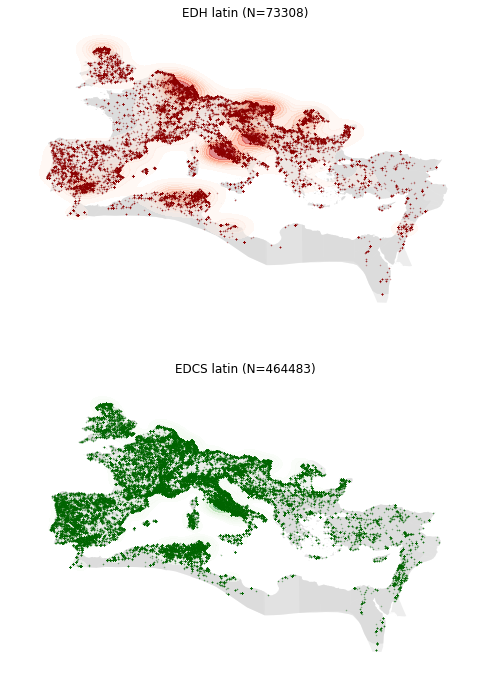

In [40]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=[24, 12])

pleiades_regions.plot(ax=ax1, color="lightgray", alpha=0.4)
geoplot.kdeplot(EDHg, cmap='Reds', shade=True, alpha=0.5, ax=ax1) # , clip=EDHg.geometry,
EDHg.plot(ax=ax1, alpha=0.4, color="darkred", markersize=0.3)
ax1.set_axis_off()
ax1.set_title("EDH latin (N={0})".format(len(EDHg)))

pleiades_regions.plot(ax=ax2, color="lightgray", alpha=0.4)
geoplot.kdeplot(EDCSg, cmap='Greens', shade=True, alpha=0.5, ax=ax2) # , clip=EDHg.geometry,
EDCSg.plot(ax=ax2, alpha=0.4, color="darkgreen", markersize=0.3)
ax2.set_axis_off()
ax2.set_title("EDCS latin (N={0})".format(len(EDCS)))

# Occupations and organizations in urban vs rural context

In [31]:
cities_pop.sort_values("pop_est", ascending=False, inplace=True)

In [32]:
len(cities_pop)

1388

In [41]:
# total urban population
cities_pop["pop_est"].sum()

10159670.0

In [42]:
# size of urban population living within 50 biggest cities
cities_pop["pop_est"][:50].sum()

4059005.0

In [43]:
cities_pop.columns

Index(['Primary Key', 'Ancient Toponym', 'Modern Toponym', 'Province',
       'Country', 'Barrington Atlas Rank', 'Barrington Atlas Reference',
       'Start Date', 'End Date', 'Longitude (X)', 'Latitude (Y)',
       'Select Bibliography', 'Area', 'Estimate Basis', 'Civic Status',
       'Structure', 'num_of_structures', 'ID', 'pop_sample', 'pop_est',
       'pop_diff', 'geometry'],
      dtype='object')

In [44]:
# create two groups of cities
cities_big = cities_pop[cities_pop["pop_est"] >= 30000]
cities_rest = cities_pop[(cities_pop["pop_est"] < 30000) & (cities_pop["pop_est"] > 1000)]
print("big cities (n={2}) - pop {0}, middle cities (n={3}) {1}".format(cities_big["pop_est"].sum(), cities_rest["pop_est"].sum(), len(cities_big), len(cities_rest)))

big cities (n=68) - pop 4641352.0, middle cities (n=690) 4942985.0


In [45]:
# by default, buffer is calculated in degrees
# we need to reproject it to calculate buffer in meters

def buffer_in_meters(lng, lat, area_ha, coef):
    proj_meters = pyproj.Proj(init='epsg:3857')
    proj_latlng = pyproj.Proj(init='epsg:4326')
    
    project_to_meters = partial(pyproj.transform, proj_latlng, proj_meters)
    project_to_latlng = partial(pyproj.transform, proj_meters, proj_latlng)
    
    pt_latlng = Point(lng, lat)
    pt_meters = transform(project_to_meters, pt_latlng)
    try:
        radius = coef # to include area radius: np.sqrt((area_ha * 10000) / np.pi) +
        buffer_meters = pt_meters.buffer(radius)
    except:
        radius = coef
        buffer_meters = pt_meters.buffer(radius)
    buffer_latlng = transform(project_to_latlng, buffer_meters)
    return buffer_latlng

In [46]:
# makes the buffer the main geometry
cities_big["geometry"] = cities_pop.apply(lambda row: buffer_in_meters(row["Longitude (X)"], row["Latitude (Y)"], row["Area"], 37000), axis=1)
cities_rest["geometry"] = cities_pop.apply(lambda row: buffer_in_meters(row["Longitude (X)"], row["Latitude (Y)"], row["Area"], 18500), axis=1)

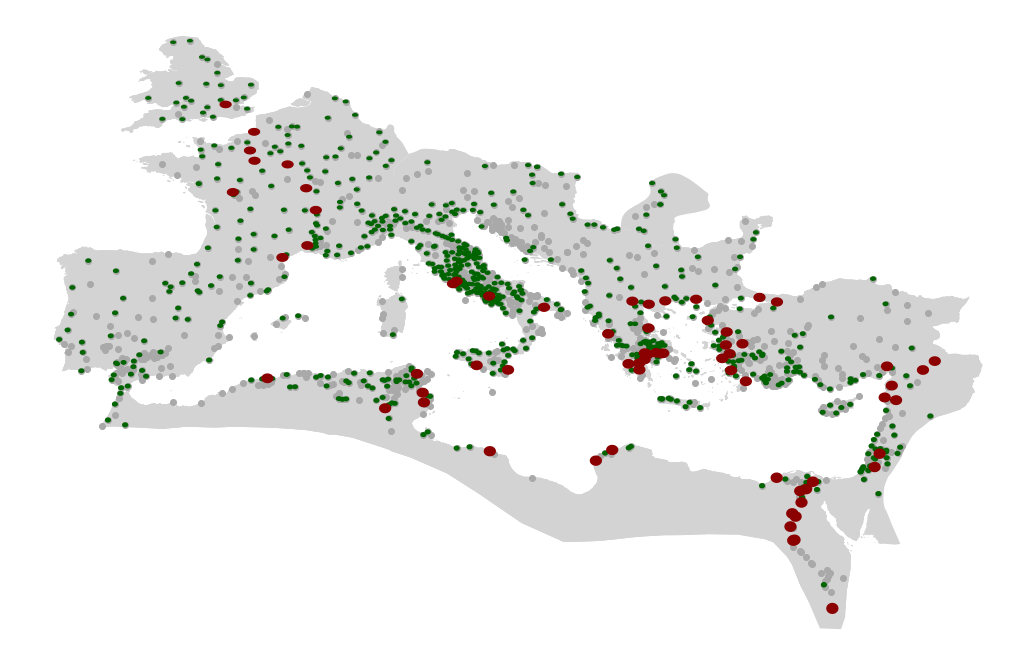

In [47]:
fig, ax = plt.subplots(figsize=[24, 12])
pleiades_regions.plot(ax=ax, color="lightgray")
cities_pop.plot(ax=ax, color="darkgrey")
cities_rest.plot(ax=ax, color="darkgreen")
cities_big.plot(ax=ax, color="darkred")
ax.set_axis_off()
#EDHg.plot(ax=ax, alpha=0.4, markersize=0.5)

In [82]:
### some inspiration from here
# https://gis.stackexchange.com/questions/349637/given-list-of-points-lat-long-how-to-find-all-points-within-radius-of-a-give

In [48]:
cities_big_multipolygon = cities_big["geometry"].unary_union
cities_rest_multipolygon = cities_rest["geometry"].unary_union

In [49]:
# for each inscription, decide whether it is in the multipolygon or not 
edh_big_cities_series = EDHg.within(cities_big_multipolygon)
edh_middle_cities_series = EDHg.within(cities_rest_multipolygon)

# working df with the same length as EDH
in_cities_df = pd.DataFrame([edh_big_cities_series, edh_middle_cities_series]).T
in_cities_df.columns = ["in_big", "in_middle"]
in_cities_df.head()

,in_big,in_middle
1,True,True
2,False,True
3,False,False
4,True,True
5,False,False


In [50]:
# for each inscription, decide whether it is in the multipolygon or not 
edcs_big_cities_series = EDCSg.within(cities_big_multipolygon)
edcs_middle_cities_series = EDCSg.within(cities_rest_multipolygon)

# working df with the same length as EDCS
in_cities_df_edcs = pd.DataFrame([edcs_big_cities_series, edcs_middle_cities_series]).T
in_cities_df_edcs.columns = ["in_big", "in_middle"]
in_cities_df_edcs.head()

,in_big,in_middle
2,True,False
3,False,False
4,False,False
5,False,False
6,False,False


In [51]:
# working df 
def get_big_middle_rest(row):
    value = "rest"
    if row["in_middle"]:
        value = "middle"
    if row["in_big"]:
        value = "big"
    return value

EDHg["urban_context"] = in_cities_df.apply(lambda row: get_big_middle_rest(row), axis=1)
EDCSg["urban_context"] = in_cities_df_edcs.apply(lambda row: get_big_middle_rest(row), axis=1)

In [82]:
# for future usage elsewhere, let's add this to the original dataset
urban_contexts_edh_dict = dict(zip(EDHg["id"].tolist(), EDHg["urban_context"].tolist()))
sddk.write_file("SDAM_data/social_diversity/urban_contexts_edh_dict.json", urban_contexts_edh_dict, conf)

urban_contexts_edcs_dict = dict(zip(EDCSg["EDCS-ID"].tolist(), EDCSg["urban_context"].tolist()))
sddk.write_file("SDAM_data/social_diversity/urban_contexts_edcs_dict.json", urban_contexts_edcs_dict, conf)

A file with the same name ("urban_contexts_edh_dict.json") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'dict'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/urban_contexts_edh_dict.json"
A file with the same name ("urban_contexts_edcs_dict.json") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'dict'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/urban_contexts_edcs_dict.json"


In [83]:
def get_urban_context(id, dataset_name):
    if dataset_name == "EDH":
        try: return urban_contexts_edh_dict[id]
        except: return "unknown"
    if dataset_name == "EDCS":
        try: return urban_contexts_edcs_dict[id]
        except: return "unknown"
        
EDH["urban_context"] = EDH["id"].apply(lambda x: get_urban_context(x, "EDH"))
EDCS["urban_context"] = EDCS["EDCS-ID"].apply(lambda x: get_urban_context(x, "EDCS"))

In [835]:
sddk.write_file("SDAM_data/social_diversity/EDH_urban_context.json", EDH, conf)

Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/EDH_urban_context.json"


In [85]:
sddk.write_file("SDAM_data/social_diversity/EDCS_urban_context.json", EDCS, conf)

A file with the same name ("EDCS_urban_context.json") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/EDCS_urban_context.json"


In [54]:
print("EDH inscriptions in big cities: ", len(EDHg[EDHg["urban_context"]=="big"]))
print("EDH inscriptionslen in middle cities: ", len(EDHg[EDHg["urban_context"]=="middle"]))
print("EDH inscriptions - rest: ", len(EDHg[EDHg["urban_context"]=="rest"]))

EDH inscriptions in big cities:  8620
EDH inscriptionslen in middle cities:  32228
EDH inscriptions - rest:  32460


In [75]:
print("EDCS inscriptions in big cities: ", len(EDCSg[EDCSg["urban_context"]=="big"]))
print("EDCS inscriptionslen in middle cities: ", len(EDCSg[EDCSg["urban_context"]=="middle"]))
print("EDCS inscriptions - rest: ", len(EDCSg[EDCSg["urban_context"]=="rest"]))

EDCS inscriptions in big cities:  130662
EDCS inscriptionslen in middle cities:  185952
EDCS inscriptions - rest:  130217


In [56]:
# occuptions frequency accross location categories
EDHg[EDHg["urban_context"]=="big"]["occups_N"].sum() / len(EDHg[EDHg["urban_context"]=="big"]), EDHg[EDHg["urban_context"]=="middle"]["occups_N"].sum() / len(EDHg[EDHg["urban_context"]=="middle"]), EDHg[EDHg["urban_context"]=="rest"]["occups_N"].sum() / len(EDHg[EDHg["urban_context"]=="rest"])

(0.060904872389791184, 0.03189772868313268, 0.01605052372150339)

In [57]:
# occuptions frequency accross location categories
EDCSg[EDCSg["urban_context"]=="big"]["occups_N"].sum() / len(EDCSg[EDCSg["urban_context"]=="big"]), EDCSg[EDCSg["urban_context"]=="middle"]["occups_N"].sum() / len(EDCSg[EDCSg["urban_context"]=="middle"]), EDCSg[EDCSg["urban_context"]=="rest"]["occups_N"].sum() / len(EDCSg[EDCSg["urban_context"]=="rest"])

(0.02456720393075263, 0.01567608845293409, 0.00736462981023983)

# Bootstrap test

Brezina 2018, p. 232, drawing on Lijffijt 2016
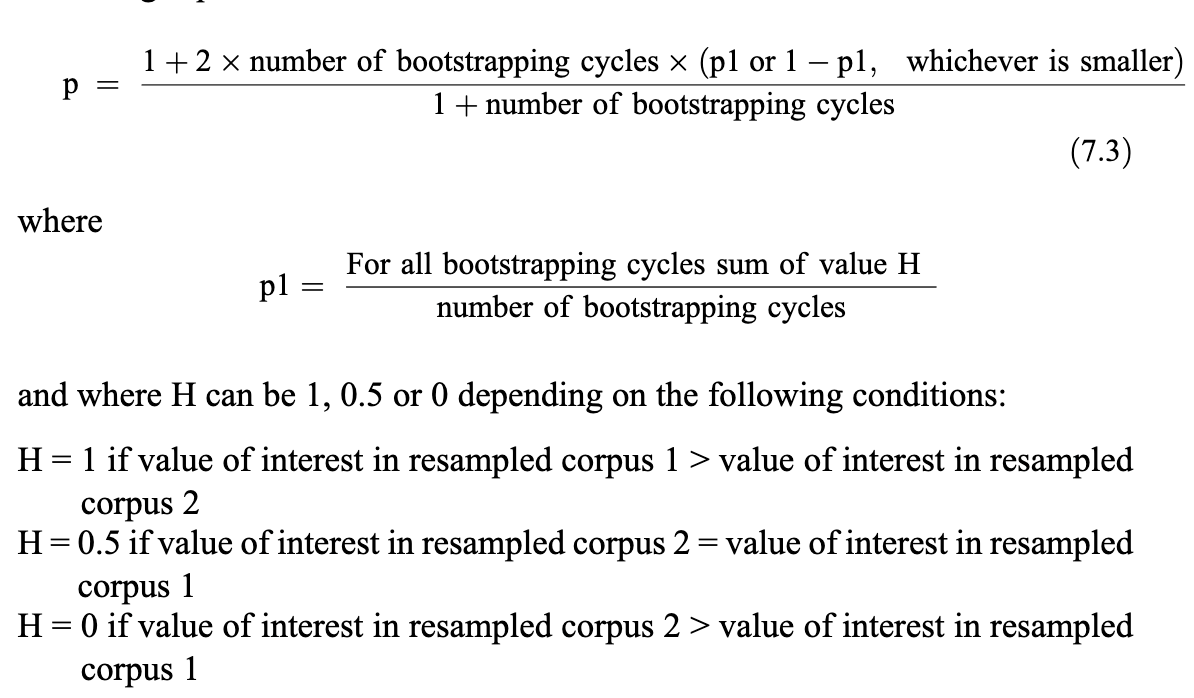

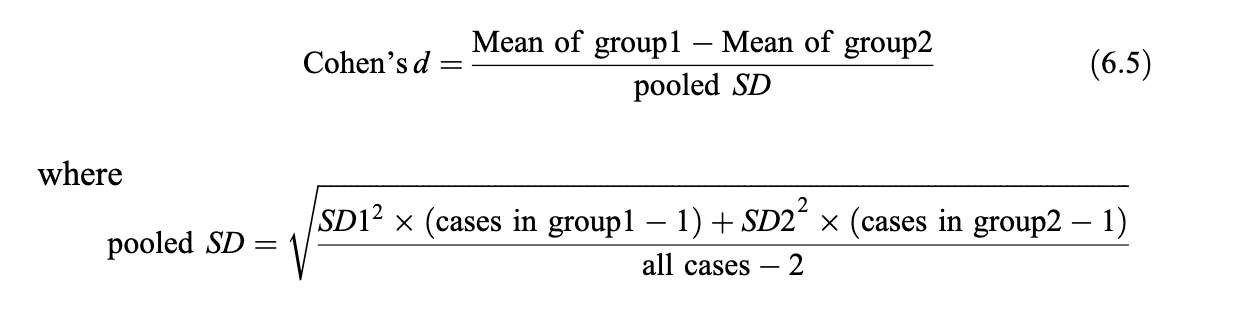

In [907]:
def get_bootstrap(df, n_of_bootstraps, bootstrap_size, column, row_function=None):
    bootstrap_values = []
    for n in range(n_of_bootstraps):
        sample_df = df.sample(bootstrap_size, replace=True)
        if row_function == None:
            bootstrap_values.append(sample_df[column].sum())
        else:
            bootstrap_values.append(sample_df[column].apply(row_function).mean())
    return bootstrap_values

def get_statistics(df1, df2, n_of_bootstraps, bootstrap_size, column, row_function=None):
    bootstrap_test_values = []
    df1_values = get_bootstrap(df1, n_of_bootstraps, bootstrap_size, column, row_function)
    df2_values = get_bootstrap(df2, n_of_bootstraps, bootstrap_size, column, row_function)
    # H values
    H_list = []
    for n in range(n_of_bootstraps):
        if df1_values[n] == df2_values[n]:
            H_list.append(0.5)
        else:
            if df1_values[n] > df2_values[n]:
                H_list.append(1)
            else:
                H_list.append(0)
    # CONFIDENCE INTERVAL (950) for the difference
    difference = np.array(df1_values) - np.array(df2_values)
    CI95 = (np.percentile(difference, 2.5), np.percentile(difference, 97.5))
    # COHENS DELTA
    pooled_sd = np.sqrt(((len(df1_values) - 1) * ((np.std(df1_values)**2))) + ((len(df2_values) - 1) * (np.std(df2_values)**2)) / (len(df1_values) + len(df2_values) + 2))
    cohens_delta = (np.mean(df1_values) - np.mean(df2_values)) / pooled_sd
    return H_list, cohens_delta, CI95, [df1_values, df2_values]

def bootstrap_test(df1, df2, n_of_bootstraps, bootstrap_size, column, row_function=None):
    H_values, cohens_delta, CI95, data = get_statistics(df1, df2, 1000, 1000, "occups_N", row_function)
    p1 =  sum(H_values) / len(H_values)
    p = (1 + (2 * len(H_values) * np.min((p1, 1 - p1)))) / (1 + len(H_values))
    return p, cohens_delta, CI95, data

In [768]:
# test1 "get_bootstrap()"
df1_values = get_bootstrap(EDHg[EDHg["urban_context"]=="big"], 1000, 1000, "occups_N")
df2_values = get_bootstrap(EDHg[EDHg["urban_context"]=="middle"], 1000, 1000, "occups_N")

print(df1_values[:10])
print(df2_values[:10])

[55, 55, 69, 67, 44, 61, 54, 72, 51, 48]
[30, 31, 32, 47, 27, 34, 39, 41, 44, 43]


In [775]:
# EDH - occupations in BIG CITIES vs MIDDLE CITIES
p, cohens_d, CI95, edh_data_occups_urban_rest = bootstrap_test(EDHg[EDHg["urban_context"]=="big"], EDHg[EDHg["urban_context"]=="middle"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.030969030969030996, 0.0811377032780686, (3.0, 50.0))

In [937]:
# EDCS - occupations in BIG CITIES vs MIDDLE CITIES
p, cohens_d, CI95, edcs_data_occups_urban_rest = bootstrap_test(EDCSg[EDCSg["urban_context"]=="big"], EDCSg[EDCSg["urban_context"]=="middle"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.26373626373626363, 0.041329729858372834, (-6.0, 25.024999999999977))

In [776]:
# EDH - occuptions in MIDDLE CITIES vs. RURAL areas
p, cohens_d, CI95, edh_data_occups_rest_rural = bootstrap_test(EDHg[EDHg["urban_context"]=="middle"], EDHg[EDHg["urban_context"]=="rest"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.06193806193806188, 0.07274247490236328, (0.0, 30.0))

In [936]:
# EDCS - occuptions in MIDDLE CITIES vs. RURAL areas
p, cohens_d, CI95, data_occups_rest_rural = bootstrap_test(EDCSg[EDCSg["urban_context"]=="middle"], EDCSg[EDCSg["urban_context"]=="rest"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.14685314685314677, 0.052149805537089304, (-3.0, 20.0))

In [933]:
# EDCS - occupations in BIG CITIES vs RURAL
p, cohens_d, CI95, edcs_data_occups_urban_rest = bootstrap_test(EDCSg[EDCSg["urban_context"]=="big"], EDCSg[EDCSg["urban_context"]=="rest"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.019980019980019886, 0.07862167593373687, (3.0, 33.0))

In [910]:
# EDH - organizations in BIG CITIES vs MIDDLE CITIES
p, cohens_d, CI95, edh_data_orgs_urban_rest = bootstrap_test(EDHg[EDHg["urban_context"]=="big"], EDHg[EDHg["urban_context"]=="middle"], 1000, 1000, "organizations_N")
p, cohens_d, CI95

(0.015984015984015887, 0.09276624511073313, (5.0, 54.0))

In [911]:
# EDCS - organizations in BIG CITIES vs MIDDLE CITIES
p, cohens_d, CI95, edcs_data_orgs_urban_rest = bootstrap_test(EDCSg[EDCSg["urban_context"]=="big"], EDCSg[EDCSg["urban_context"]=="middle"], 1000, 1000, "organizations_N")
p, cohens_d, CI95

(0.28971028971028967, 0.039585531115743144, (-7.0, 27.0))

In [912]:
# EDH - organizations in MIDDLE CITIES vs. RURAL areas
p, cohens_d, CI95, edh_data_orgs_rest_rural = bootstrap_test(EDHg[EDHg["urban_context"]=="middle"], EDHg[EDHg["urban_context"]=="rest"], 1000, 1000, "organizations_N")
p, cohens_d, CI95

(0.048951048951048994, 0.07313375127747032, (0.0, 32.0))

In [913]:
# EDCS - organizations in MIDDLE CITIES vs. RURAL areas
p, cohens_d, CI95, edcs_data_orgs_rest_rural = bootstrap_test(EDCSg[EDCSg["urban_context"]=="middle"], EDCSg[EDCSg["urban_context"]=="rest"], 1000, 1000, "organizations_N")
p, cohens_d, CI95

(0.13886113886113874, 0.05160096450213578, (-2.0249999999999986, 20.0))

In [ ]:
labels=[
    "cities\npop. est.  ≥ 30K",
    "cities\npop. est. > 1K",
    "rural regions\nor minor\ncities"
]

In [ ]:
# experiment with jitter plot....
data_occups = pd.DataFrame([edh_data_occups_urban_rest[0] + edh_data_occups_urban_rest[1] + edh_data_occups_rest_rural[1], [labels[0]] * 1000  + [labels[1]] * 1000 + [labels[2]] * 1000]).T
data_occups.columns=["occups_per_1000", "urb_cat"]
sns.stripplot(x="urb_cat", y="occups_per_1000", data=data_occups, alpha=0.25)

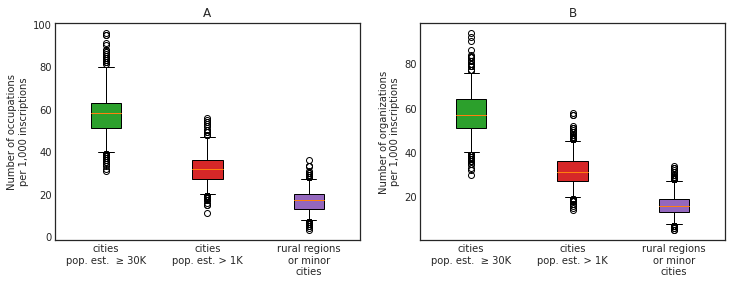

In [818]:
### EDH

plt.style.use("seaborn-white")
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

labels=[
    "cities\npop. est.  ≥ 30K",
    "cities\npop. est. > 1K",
    "rural regions\nor minor\ncities"
]

fig, [ax1, ax2] = plt.subplots(1,2, figsize=[12,4])

bplot1 = ax1.boxplot(edh_data_occups_urban_rest + [edh_data_occups_rest_rural[1]], whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax1.set_title("A")
ax1.set_ylabel("Number of occupations\nper 1,000 inscriptions")

bplot2 = ax2.boxplot(edh_data_orgs_urban_rest + [edh_data_orgs_rest_rural[1]], whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax2.set_title("B")
ax2.set_ylabel("Number of organizations\nper 1,000 inscriptions")

# fill with colors
colors =tab_colors_list[2:][:len(labels)]
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

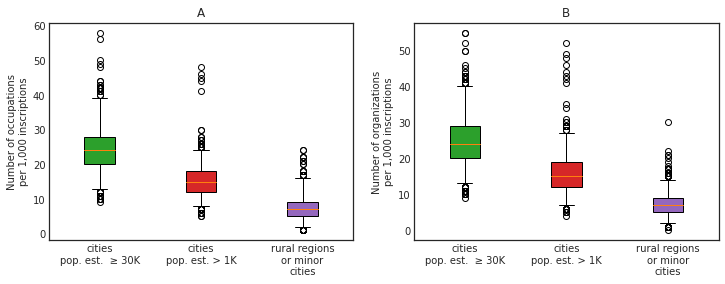

In [914]:
# EDCS

plt.style.use("seaborn-white")
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

labels=[
    "cities\npop. est.  ≥ 30K",
    "cities\npop. est. > 1K",
    "rural regions\nor minor\ncities"
]

fig, [ax1, ax2] = plt.subplots(1,2, figsize=[12,4])

bplot1 = ax1.boxplot(edcs_data_occups_urban_rest + [edcs_data_occups_rest_rural[1]], whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax1.set_title("A")
ax1.set_ylabel("Number of occupations\nper 1,000 inscriptions")

bplot2 = ax2.boxplot(edcs_data_orgs_urban_rest + [edcs_data_orgs_rest_rural[1]], whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax2.set_title("B")
ax2.set_ylabel("Number of organizations\nper 1,000 inscriptions")

# fill with colors
colors =tab_colors_list[2:][:len(labels)]
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# By industry type

In [822]:
occupations_df = get_as_dataframe(occupations.worksheet("Occupation"))
occupations_df = occupations_df[['Term', 'gen_sg', 'Vocab_nom_sg', 'Source', 'Category', 'Subcategory','Translation_eng']]
occupations_df = occupations_df.dropna(thresh=5)
occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["Category"]))

In [938]:
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in list_of_occups]
    except:
        return []
    
EDHg["occups_cats"] = EDHg["occups"].apply(cat_for_occup)
EDCSg["occups_cats"] = EDCSg["occups"].apply(cat_for_occup)

In [939]:
edh_occups_cats_data = {}
edcs_occups_cats_data = {}



labels=[
    "cities\npop. est.  ≥ 30K",
    "cities\npop. est. > 1K",
    "rural regions\nor minor\ncities"
]
edh_all_present_categories = []
for df_subset, subset_title in zip([EDHg[EDHg["urban_context"]=="big"], EDHg[EDHg["urban_context"]=="middle"], EDHg[EDHg["urban_context"]=="rest"]], labels):
    occups_cats_list = [el for sublist in df_subset["occups_cats"].tolist() for el in sublist]
    wordcount = df_subset["clean_text_interpretive_word"].astype("str").apply(lambda x: len(x.split())).sum()
    occups_cats_dist = nltk.FreqDist(occups_cats_list).most_common()
    categories = [tup[0] for tup in occups_cats_dist]
    edh_all_present_categories.extend(categories[:10])
    freqs = [(tup[1] / wordcount) * 10000 for tup in occups_cats_dist]
    cat_freq_dict = dict(zip(categories[:10], freqs[:10]))
    total_freq = np.sum(freqs)
    edh_occups_cats_data[subset_title] = {"categories" : categories, "freqs" : freqs, "cat_freq_dict" : cat_freq_dict,"total_freq" : total_freq}
    print(categories, freqs, total_freq)
edh_all_present_categories = list(set(edh_all_present_categories))

['Metal-Working', 'Miscellaneous Services', 'Managerial', 'Education', 'Building', 'Transport', 'Retail', 'Clothing', 'Food-Production', 'Performing Arts', 'Plastic Arts', 'Household Goods', 'Finance', 'Food-Retail', 'Fuel / Raw material', 'Glass-Working', 'Water-Management'] [8.034740688309453, 6.695617240257877, 4.527512610079135, 2.423175763140946, 2.168104630178741, 1.9130334972165364, 1.6579623642543315, 1.59419458101378, 1.59419458101378, 1.0840523150893706, 0.5739100491649609, 0.3826066994433073, 0.31883891620275606, 0.31883891620275606, 0.06376778324055121, 0.06376778324055121, 0.06376778324055121] 33.478086201289386
['Metal-Working', 'Managerial', 'Miscellaneous Services', 'Retail', 'Building', 'Performing Arts', 'Education', 'Clothing', 'Food-Production', 'Finance', 'Plastic Arts', 'Transport', 'Food-Retail', 'Household Goods', 'Water-Management', 'Death-care sector', 'Glass-Working', 'Unclear meaning'] [8.305123208257399, 3.0413127241505964, 3.0413127241505964, 1.54405107533

In [940]:
edcs_all_present_categories = []
for df_subset, subset_title in zip([EDCSg[EDCSg["urban_context"]=="big"], EDCSg[EDCSg["urban_context"]=="middle"], EDCSg[EDCSg["urban_context"]=="rest"]], labels):
    occups_cats_list = [el for sublist in df_subset["occups_cats"].tolist() for el in sublist]
    wordcount = df_subset["clean_text_interpretive_word"].astype("str").apply(lambda x: len(x.split())).sum()
    occups_cats_dist = nltk.FreqDist(occups_cats_list).most_common()
    categories = [tup[0] for tup in occups_cats_dist]
    edh_all_present_categories.extend(categories[:10])
    freqs = [(tup[1] / wordcount) * 10000 for tup in occups_cats_dist]
    cat_freq_dict = dict(zip(categories[:10], freqs[:10]))
    total_freq = np.sum(freqs)
    edh_occups_cats_data[subset_title] = {"categories" : categories, "freqs" : freqs, "cat_freq_dict" : cat_freq_dict,"total_freq" : total_freq}
    print(categories, freqs, total_freq)
edh_all_present_categories = list(set(edh_all_present_categories))

['Metal-Working', 'Miscellaneous Services', 'Managerial', 'Food-Production', 'Building', 'Education', 'Retail', 'Clothing', 'Transport', 'Household Goods', 'Performing Arts', 'Finance', 'Food-Retail', 'Plastic Arts', 'Water-Management', 'Glass-Working', 'Fuel / Raw material', 'Death-care sector', 'Unclear meaning'] [5.275268146534537, 4.406400451811201, 3.149645393372091, 1.7765241258182485, 1.7299776421723554, 1.6911889058007779, 1.4584564875713133, 1.4041522566511047, 1.0007493983866989, 0.768016980157234, 0.7369859910599721, 0.5275268146534536, 0.42667610008735224, 0.3103098909726198, 0.12412395638904791, 0.062061978194523956, 0.023273241822946485, 0.015515494548630989, 0.015515494548630989] 24.902368750552736
['Metal-Working', 'Miscellaneous Services', 'Managerial', 'Building', 'Performing Arts', 'Retail', 'Education', 'Clothing', 'Food-Production', 'Transport', 'Household Goods', 'Finance', 'Plastic Arts', 'Food-Retail', 'Glass-Working', 'Water-Management', 'Unclear meaning', 'Dea

In [941]:
edh_data_by_category = {}
for cat in edh_all_present_categories:
    cat_data = []
    for label in labels:
        try:
            cat_data.append(occups_cats_data[label]["cat_freq_dict"][cat])
        except:
            cat_data.append(0)
    edh_data_by_category[cat] = cat_data

In [955]:
edh_data_by_category

{'Food-Production': [1.548171966178397, 0.8791228112589258, 0.594486820684483],
 'Education': [2.381803024889842, 1.1428596546366037, 0.548757065247215],
 'Finance': [0, 0.5054956164738824, 0],
 'Performing Arts': [1.0122662855781828,
  1.4725307088587007,
  0.617351698403117],
 'Retail': [1.548171966178397, 1.4725307088587007, 0.8460004755894566],
 'Clothing': [1.6077170418006432, 0.8791228112589258, 0.3658380434981434],
 'Household Goods': [0, 0, 0],
 'Transport': [1.7863522686673812, 0, 0.4344326766540453],
 'Managerial': [4.4063355960462065, 3.032973698843294, 1.4633521739925737],
 'Metal-Working': [8.157675360247708, 8.153864074426536, 4.481516032852256],
 'Miscellaneous Services': [6.31177801595808,
  3.14286405025066,
  2.30935264958203],
 'Building': [2.0245325711563655, 1.6043991305475398, 0.9374599864639923]}

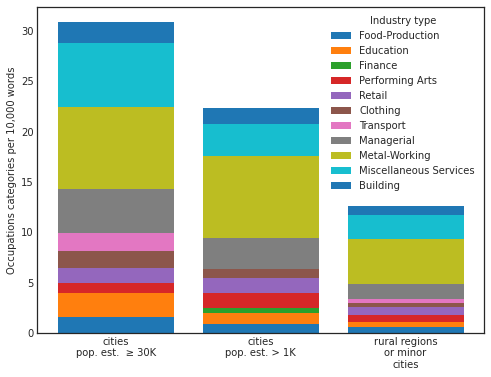

In [828]:
plt.style.use("seaborn-white")

fig, ax = plt.subplots(figsize=[8,6])
first_bar_cat = list(data_by_category.keys())[0]
ax.bar(labels, data_by_category[first_bar_cat], label=first_bar_cat)
bottom = data_by_category[first_bar_cat]
for cat in list(data_by_category.keys())[1:]:
    ax.bar(labels, data_by_category[cat], bottom = bottom, label=cat)
    bottom += np.array(data_by_category[cat])
ax.set_ylabel("Occupations categories per 10,000 words")
ax.legend(title="Industry type", bbox_to_anchor=(1, 1))


In [953]:
edcs_data_by_category = {}
for cat in edcs_all_present_categories:
    cat_data = []
    for label in labels:
        try:
            cat_data.append(edcs_occups_cats_data[label]["cat_freq_dict"][cat])
        except:
            cat_data.append(0)
    edcs_data_by_category[cat] = cat_data

In [1]:
edcs_data_by_category

NameError: name 'edcs_data_by_category' is not defined

IndexError: list index out of range

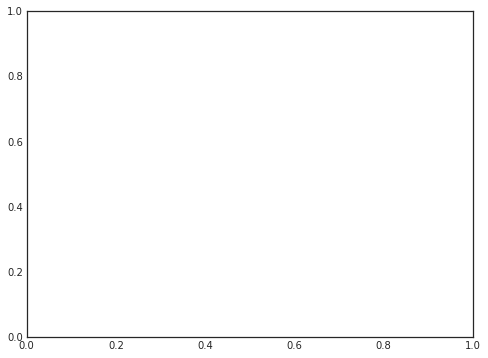

In [951]:
plt.style.use("seaborn-white")

fig, ax = plt.subplots(figsize=[8,6])
first_bar_cat = list(edcs_data_by_category.keys())[0]
ax.bar(labels, edcs_data_by_category[first_bar_cat], label=first_bar_cat)
bottom = edcs_data_by_category[first_bar_cat]
for cat in list(edcs_data_by_category.keys())[1:]:
    ax.bar(labels, edcs_data_by_category[cat], bottom = bottom, label=cat)
    bottom += np.array(edcs_data_by_category[cat])
ax.set_ylabel("Occupations categories per 10,000 words")
ax.legend(title="Industry type", bbox_to_anchor=(1, 1))